In [5]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
import time 

# Problem 1: Digit Recognizer

In [6]:
# Loading the dataset
dataset = np.load("dataset.npz")
X, y = dataset["X"], dataset["y"]

## Data exploration and pre-processing

In [7]:
# Print a random sample to visualise it
print(y[5])

8


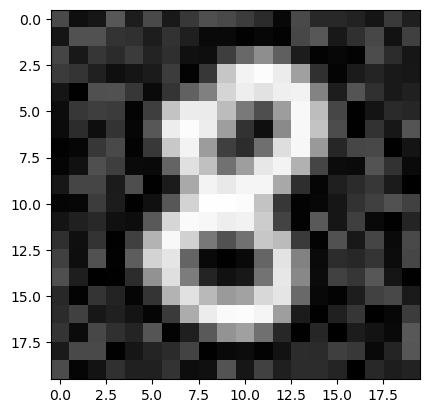

In [8]:
# Here we can see more clearly that it is a 8
plt.imshow(X[5].reshape(20,20), vmin=0, vmax=255.0, cmap="gray")
plt.show()

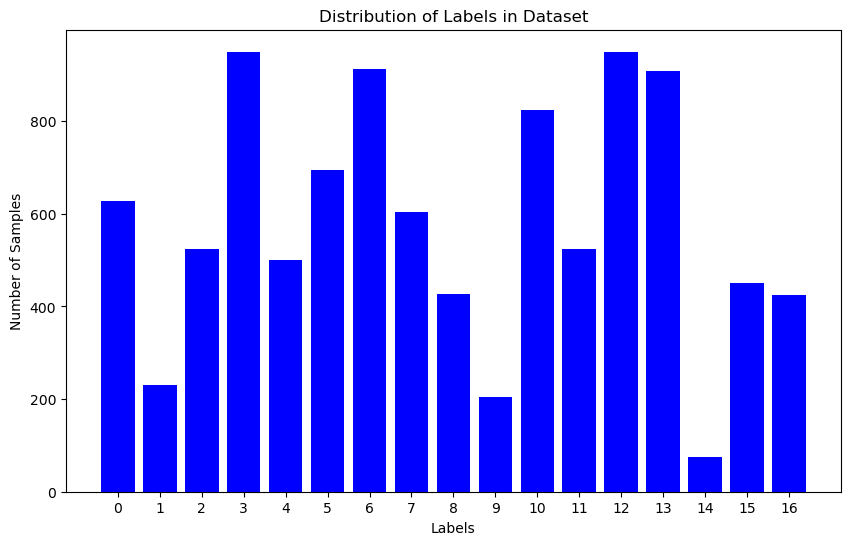

Highest count of classes:  950
Lowest count of classes:  74


In [9]:
# Visualizing the distribution of classes in the dataset
label_counts = Counter(y)
labels = list(label_counts.keys())
counts = list(label_counts.values())
sorted_labels_counts = sorted(zip(labels, counts), key=lambda x: x[0])
sorted_labels, sorted_counts = zip(*sorted_labels_counts)


plt.figure(figsize=(10, 6))
plt.bar(sorted_labels, sorted_counts, color='blue')
plt.xlabel('Labels')
plt.ylabel('Number of Samples')
plt.title('Distribution of Labels in Dataset')
plt.xticks(sorted_labels)  
plt.show()

print("Highest count of classes: ", max(label_counts.values()))
print("Lowest count of classes: ", min(label_counts.values()))


Above we see that the classes has very different amount of samples. Class 14 has only 74, and class 3 as as much as 950. This means that there is a imbalance in the dataset that we need to account for. Our approach will be to oversample our data so that we remove the imbalance.

The reason we chose to oversample is because this improves performance on minority classes.
We know that oversampling can lead to overfitting since we have more of the same data and with oversampling it increases computational cost for us to train and tune since it has more data to go through. But we think it is worth it, and we are choosing to use k-fold cross validation when we are tuning to account for overfitting risks.

In [10]:
# For reproducability
# Set seed 
seed = 0
np.random.seed(seed)

In [11]:
#Split the data into test and (training and validation)
X_train_val, X_test, y_train_val, y_test = train_test_split(X,y, test_size=0.3, random_state=seed, shuffle=True)

# We normalize so that whatever classifier we choose all features will contribute equally. (This is not needed for random forest, but it is for others.)
# Normalize the data to [0, 1] 
X_train_val = X_train_val / 255.0
X_test = X_test / 255.0

# Oversample with Smote
smote = SMOTE(random_state=seed)
X_train_val, y_train_val = smote.fit_resample(X_train_val, y_train_val)

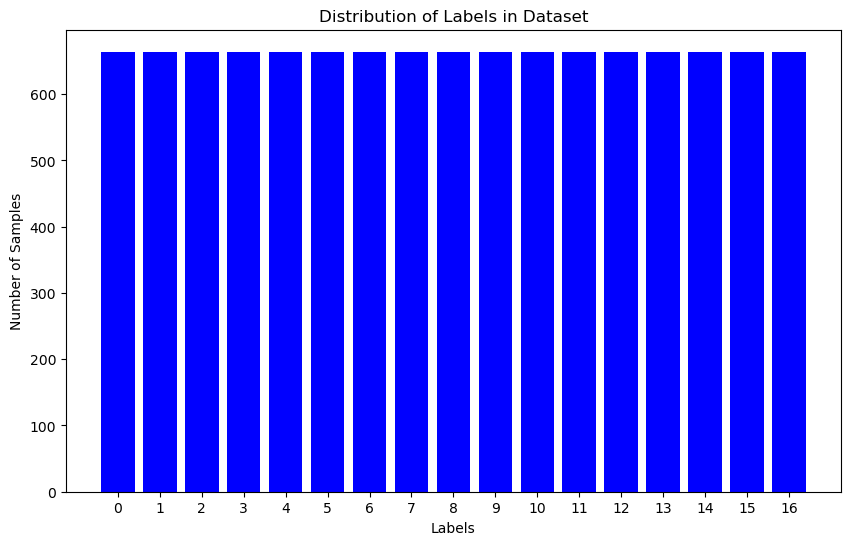

Highest count of classes:  664
Lowest count of classes:  664


In [12]:
# Visualizing the distribution of classes in the dataset now after oversampling
label_counts = Counter(y_train_val)
labels = list(label_counts.keys())
counts = list(label_counts.values())
sorted_labels_counts = sorted(zip(labels, counts), key=lambda x: x[0])
sorted_labels, sorted_counts = zip(*sorted_labels_counts)


plt.figure(figsize=(10, 6))
plt.bar(sorted_labels, sorted_counts, color='blue')
plt.xlabel('Labels')
plt.ylabel('Number of Samples')
plt.title('Distribution of Labels in Dataset')
plt.xticks(sorted_labels)  
plt.show()

print("Highest count of classes: ", max(label_counts.values()))
print("Lowest count of classes: ", min(label_counts.values()))

### After oversampling

We see that the distribution has no imbalance now after oversampling.

# Random Forest classifier

In [13]:
rf = RandomForestClassifier(random_state=seed, class_weight='balanced')

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [10,15,20,40,100],  # Number of trees in the forest
    'max_depth': [None, 10,15,20,30],  # Maximum depth of the trees
    'max_features': ['sqrt','log2'], # Number of features to consider for best split
    'criterion': ['entropy','gini']
}   

param_grid = {
    'n_estimators': [100],  # Number of trees in the forest
    'max_depth': [None],  # Maximum depth of the trees
    'max_features': ['sqrt'], # Number of features to consider for best split
    'criterion': ['entropy']
}  


grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           scoring='accuracy', 
                           cv=5, n_jobs=-1, verbose=0)

grid_search.fit(X_train_val, y_train_val)


print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation accuracy:", grid_search.best_score_)

#Here we can use accruacy when tuning since we removed the imbalance

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}
Best Cross-Validation accuracy: 0.9481788966361124


# SVM


In [14]:
svm = SVC(random_state = seed)

param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel type to be used in the algorithm
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'degree': [2, 3, 4]  # Degree of the polynomial kernel function ('poly')
}

param_grid = {
    'C': [10],  # Regularization parameter
    'kernel': ['rbf'],  # Kernel type to be used in the algorithm
    'gamma': ['scale'],  # Kernel coefficient
    'degree': [2]  # Degree of the polynomial kernel function ('poly')
}

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, 
                           scoring='accuracy',  
                           cv=5, n_jobs=-1, verbose=2)


grid_search.fit(X_train_val, y_train_val)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Hyperparameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation accuracy: 0.9712109908627935


### Choosing the best classifier:
We see that SVM gave us the best cross-validation accuracy. Because of this we chose to go with this further.

In [15]:
# Evaluate the best model on the test set
best_svm = grid_search.best_estimator_

# Here we use classification report so that we can see how well the classifier performs on each class
print(classification_report(y_test, best_svm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       184
           1       0.89      1.00      0.94        77
           2       0.93      0.84      0.88       151
           3       0.96      0.95      0.95       292
           4       0.86      0.92      0.89       142
           5       0.93      0.90      0.91       207
           6       0.96      0.96      0.96       248
           7       0.92      0.95      0.94       195
           8       0.91      0.84      0.87       129
           9       0.94      0.77      0.84        60
          10       0.90      0.93      0.92       242
          11       0.88      0.86      0.87       174
          12       0.96      0.95      0.96       303
          13       0.86      0.91      0.89       272
          14       1.00      0.64      0.78        22
          15       0.85      0.91      0.88       140
          16       1.00      1.00      1.00       113

    accuracy              

# Problem 2:  Dimensionality Reduction

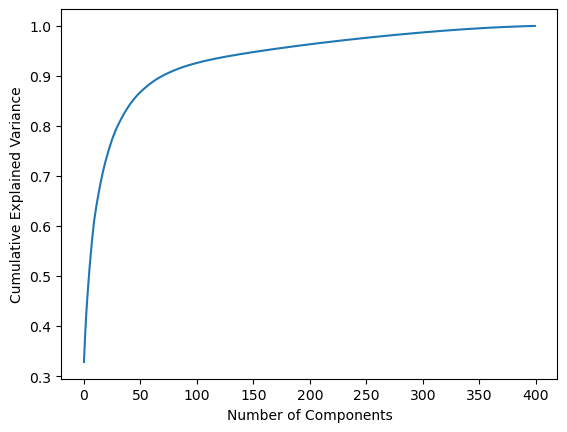

In [16]:
from sklearn.decomposition import PCA
pca = PCA(random_state=seed).fit(X_train_val)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [17]:
from sklearn.decomposition import PCA

# List of n_components values to test
n_components_list = [10, 20, 50, 100, 200, 300]

# Define a structure to store the results
results = []

# Define the hyperparameters to tune
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel type to be used in the algorithm
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'degree': [2, 3, 4]  # Degree of the polynomial kernel function ('poly')
}

param_grid = {
    'C': [10],  # Regularization parameter
    'kernel': ['rbf'],  # Kernel type to be used in the algorithm
    'gamma': ['scale'],  # Kernel coefficient
    'degree': [2]  # Degree of the polynomial kernel function ('poly')
}


for dimensions in n_components_list:
    # print(f"\nTesting with {dimensions} components")
    start_time = time.time()

    # Perform PCA
    pca = PCA(n_components=dimensions, random_state=seed)
    X_train_val_pca = pca.fit_transform(X_train_val)
    X_test_pca = pca.transform(X_test)

    # Calculate total variance explained
    total_variance_explained = pca.explained_variance_ratio_.sum()
    

    # Set up GridSearchCV with SVM
    svm = SVC(random_state = seed)
    grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, 
                               scoring='accuracy', 
                               cv=5, n_jobs=-1, verbose=0)
    
    # Fit the grid search to the data
    grid_search.fit(X_train_val_pca, y_train_val)
    
    # Get the best hyperparameters and cross-validation accuracy
    best_hyperparams = grid_search.best_params_
    best_cv_accuracy = grid_search.best_score_
    

    best_svm = grid_search.best_estimator_
    best_svm.fit(X_train_val_pca, y_train_val)

    

    test_predictions = best_svm.predict(X_test_pca)
    class_report = classification_report(y_test, test_predictions, output_dict=False)

    end_time = time.time()
    execution_time = end_time - start_time
    
    # Store the results in the results list
    results.append({
        'n_components': dimensions,
        'total_variance_explained': total_variance_explained,
        'best_hyperparameters': best_hyperparams,
        'best_cv_accuracy': best_cv_accuracy,
        'classification_report': class_report,
        'execution_time': execution_time
    })



## Results when PCA is set to n_components = 10:

In [18]:
for key, val in results[0].items():
    if key != "classification_report":
        print(f"{key}: {val}")    

n_components: 10
total_variance_explained: 0.6101684689703556
best_hyperparameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
best_cv_accuracy: 0.9024679051846572
execution_time: 4.577947616577148


In [19]:
for key, val in results[0].items():
    if key == "classification_report":
        print(f"{val}")            

              precision    recall  f1-score   support

           0       0.74      0.79      0.77       184
           1       0.94      0.97      0.96        77
           2       0.84      0.78      0.81       151
           3       0.95      0.87      0.91       292
           4       0.86      0.90      0.88       142
           5       0.84      0.86      0.85       207
           6       0.86      0.82      0.84       248
           7       0.89      0.87      0.88       195
           8       0.75      0.66      0.70       129
           9       0.77      0.67      0.71        60
          10       0.87      0.89      0.88       242
          11       0.65      0.74      0.69       174
          12       0.90      0.85      0.88       303
          13       0.74      0.78      0.76       272
          14       0.44      0.73      0.55        22
          15       0.73      0.76      0.74       140
          16       1.00      1.00      1.00       113

    accuracy              

## Results when PCA is set to n_components = 20:

In [20]:
for key, val in results[1].items():
    if key != "classification_report":
        print(f"{key}: {val}")   

n_components: 20
total_variance_explained: 0.7286730680191779
best_hyperparameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
best_cv_accuracy: 0.9588092630230601
execution_time: 4.215202808380127


In [21]:
for key, val in results[1].items():
    if key == "classification_report":
        print(f"{val}")   

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       184
           1       0.94      0.99      0.96        77
           2       0.92      0.85      0.88       151
           3       0.93      0.93      0.93       292
           4       0.85      0.89      0.87       142
           5       0.92      0.89      0.90       207
           6       0.94      0.96      0.95       248
           7       0.92      0.94      0.93       195
           8       0.87      0.86      0.86       129
           9       0.90      0.75      0.82        60
          10       0.91      0.91      0.91       242
          11       0.84      0.84      0.84       174
          12       0.96      0.93      0.94       303
          13       0.85      0.88      0.86       272
          14       0.78      0.64      0.70        22
          15       0.84      0.86      0.85       140
          16       1.00      1.00      1.00       113

    accuracy              

## Results when PCA is set to n_components = 50:

In [22]:
for key, val in results[2].items():
    if key != "classification_report":
        print(f"{key}: {val}")  

n_components: 50
total_variance_explained: 0.8657932159435444
best_hyperparameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
best_cv_accuracy: 0.971564972746927
execution_time: 4.482701539993286


In [23]:
for key, val in results[2].items():
    if key == "classification_report":
        print(f"{val}")  

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       184
           1       0.90      1.00      0.94        77
           2       0.91      0.87      0.89       151
           3       0.97      0.96      0.96       292
           4       0.89      0.93      0.91       142
           5       0.94      0.92      0.93       207
           6       0.96      0.96      0.96       248
           7       0.92      0.96      0.94       195
           8       0.94      0.88      0.91       129
           9       0.98      0.78      0.87        60
          10       0.92      0.93      0.92       242
          11       0.91      0.88      0.89       174
          12       0.95      0.94      0.95       303
          13       0.88      0.91      0.89       272
          14       0.89      0.73      0.80        22
          15       0.86      0.90      0.88       140
          16       1.00      1.00      1.00       113

    accuracy              

## Results when PCA is set to n_components = 100:

In [24]:
for key, val in results[3].items():
    if key != "classification_report":
        print(f"{key}: {val}")  

n_components: 100
total_variance_explained: 0.9254948611719924
best_hyperparameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
best_cv_accuracy: 0.9720964949906854
execution_time: 6.105645179748535


In [25]:
for key, val in results[3].items():
    if key == "classification_report":
        print(f"{val}")  

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       184
           1       0.91      1.00      0.95        77
           2       0.93      0.85      0.89       151
           3       0.96      0.96      0.96       292
           4       0.88      0.92      0.90       142
           5       0.94      0.90      0.92       207
           6       0.97      0.96      0.96       248
           7       0.93      0.96      0.95       195
           8       0.89      0.84      0.87       129
           9       0.94      0.80      0.86        60
          10       0.90      0.93      0.92       242
          11       0.89      0.86      0.87       174
          12       0.96      0.96      0.96       303
          13       0.87      0.90      0.89       272
          14       0.94      0.73      0.82        22
          15       0.86      0.91      0.89       140
          16       1.00      1.00      1.00       113

    accuracy              

## Results when PCA is set to n_components = 200:

In [26]:
for key, val in results[4].items():
    if key != "classification_report":
        print(f"{key}: {val}")  

n_components: 200
total_variance_explained: 0.9630831404922299
best_hyperparameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
best_cv_accuracy: 0.9728053613735126
execution_time: 10.556917905807495


In [27]:
for key, val in results[4].items():
    if key == "classification_report":
        print(f"{val}") 

              precision    recall  f1-score   support

           0       0.89      0.90      0.89       184
           1       0.87      1.00      0.93        77
           2       0.95      0.85      0.90       151
           3       0.96      0.96      0.96       292
           4       0.85      0.91      0.88       142
           5       0.94      0.91      0.92       207
           6       0.96      0.96      0.96       248
           7       0.93      0.96      0.94       195
           8       0.92      0.84      0.87       129
           9       0.94      0.78      0.85        60
          10       0.90      0.93      0.91       242
          11       0.89      0.87      0.88       174
          12       0.96      0.95      0.96       303
          13       0.87      0.92      0.89       272
          14       1.00      0.64      0.78        22
          15       0.87      0.91      0.89       140
          16       1.00      1.00      1.00       113

    accuracy              

## Results when PCA is set to n_components = 300:

In [28]:
for key, val in results[5].items():
    if key != "classification_report":
        print(f"{key}: {val}")  

n_components: 300
total_variance_explained: 0.9868889040899241
best_hyperparameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
best_cv_accuracy: 0.9717424346183294
execution_time: 15.229359865188599


In [29]:
for key, val in results[5].items():
    if key == "classification_report":
        print(f"{val}") 

              precision    recall  f1-score   support

           0       0.89      0.88      0.88       184
           1       0.89      1.00      0.94        77
           2       0.94      0.85      0.89       151
           3       0.97      0.95      0.96       292
           4       0.86      0.92      0.89       142
           5       0.92      0.91      0.91       207
           6       0.96      0.96      0.96       248
           7       0.93      0.96      0.94       195
           8       0.92      0.84      0.88       129
           9       0.94      0.77      0.84        60
          10       0.90      0.94      0.92       242
          11       0.88      0.87      0.88       174
          12       0.96      0.95      0.96       303
          13       0.86      0.92      0.89       272
          14       1.00      0.64      0.78        22
          15       0.84      0.91      0.87       140
          16       1.00      1.00      1.00       113

    accuracy              

### Thoughts
We se that the n_components 


Compare (performance and computational efficiency)

# Problem 3: Detecting Out-of-Distribution Images


Different approaches to find the out of dist images:


Approach 1: Based on the smallest difference between the top two probabilities.
Approach 2: Based on entropy, which measures the overall uncertainty of the probability distribution.


We counted which of these approaches had the most out of distribution images in them and went with that one.

If we could find all of the images we would count 85, this way we can kinda find a accuracy for finding these!

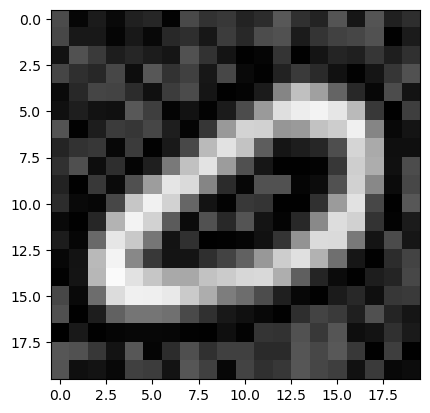

In [30]:
# Loading the dataset
dataset = np.load("corrupt_dataset.npz")
X = dataset["X"]

# Normalise the data
X = X / 255.0

x = 324

# Define a threshold
# threshold = 0.6

# Apply threshold to binarize the image data
# X = (X >= threshold).astype(int)

# Visualize the binarized image for sample x
plt.imshow(X[x].reshape(20, 20), vmin=0, vmax=1, cmap="gray")
plt.show()

In [31]:
# I want to use SVM with PCA set to 100, because this gave me the best results:
svm = SVC(random_state = seed, probability=True, C=10,  degree=2 , gamma='scale', kernel='rbf' )

PCA
pca = PCA(n_components=100, random_state=seed)
X_train_val_pca = pca.fit_transform(X_train_val)
X_corrupt_pca = pca.transform(X)
svm.fit(X_train_val_pca, y_train_val)

# X_train_val = (X_train_val >= threshold).astype(int)


predicts = svm.predict_proba(X_corrupt_pca)

# best_hyperparameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}

# plt.imshow(X[x].reshape(20,20), vmin=0, vmax=1, cmap="gray")
# plt.show()

# X_test = (X_test >= threshold).astype(int)

# print(classification_report(y_test, svm.predict(X_test)))

### Showing all of the pictures:

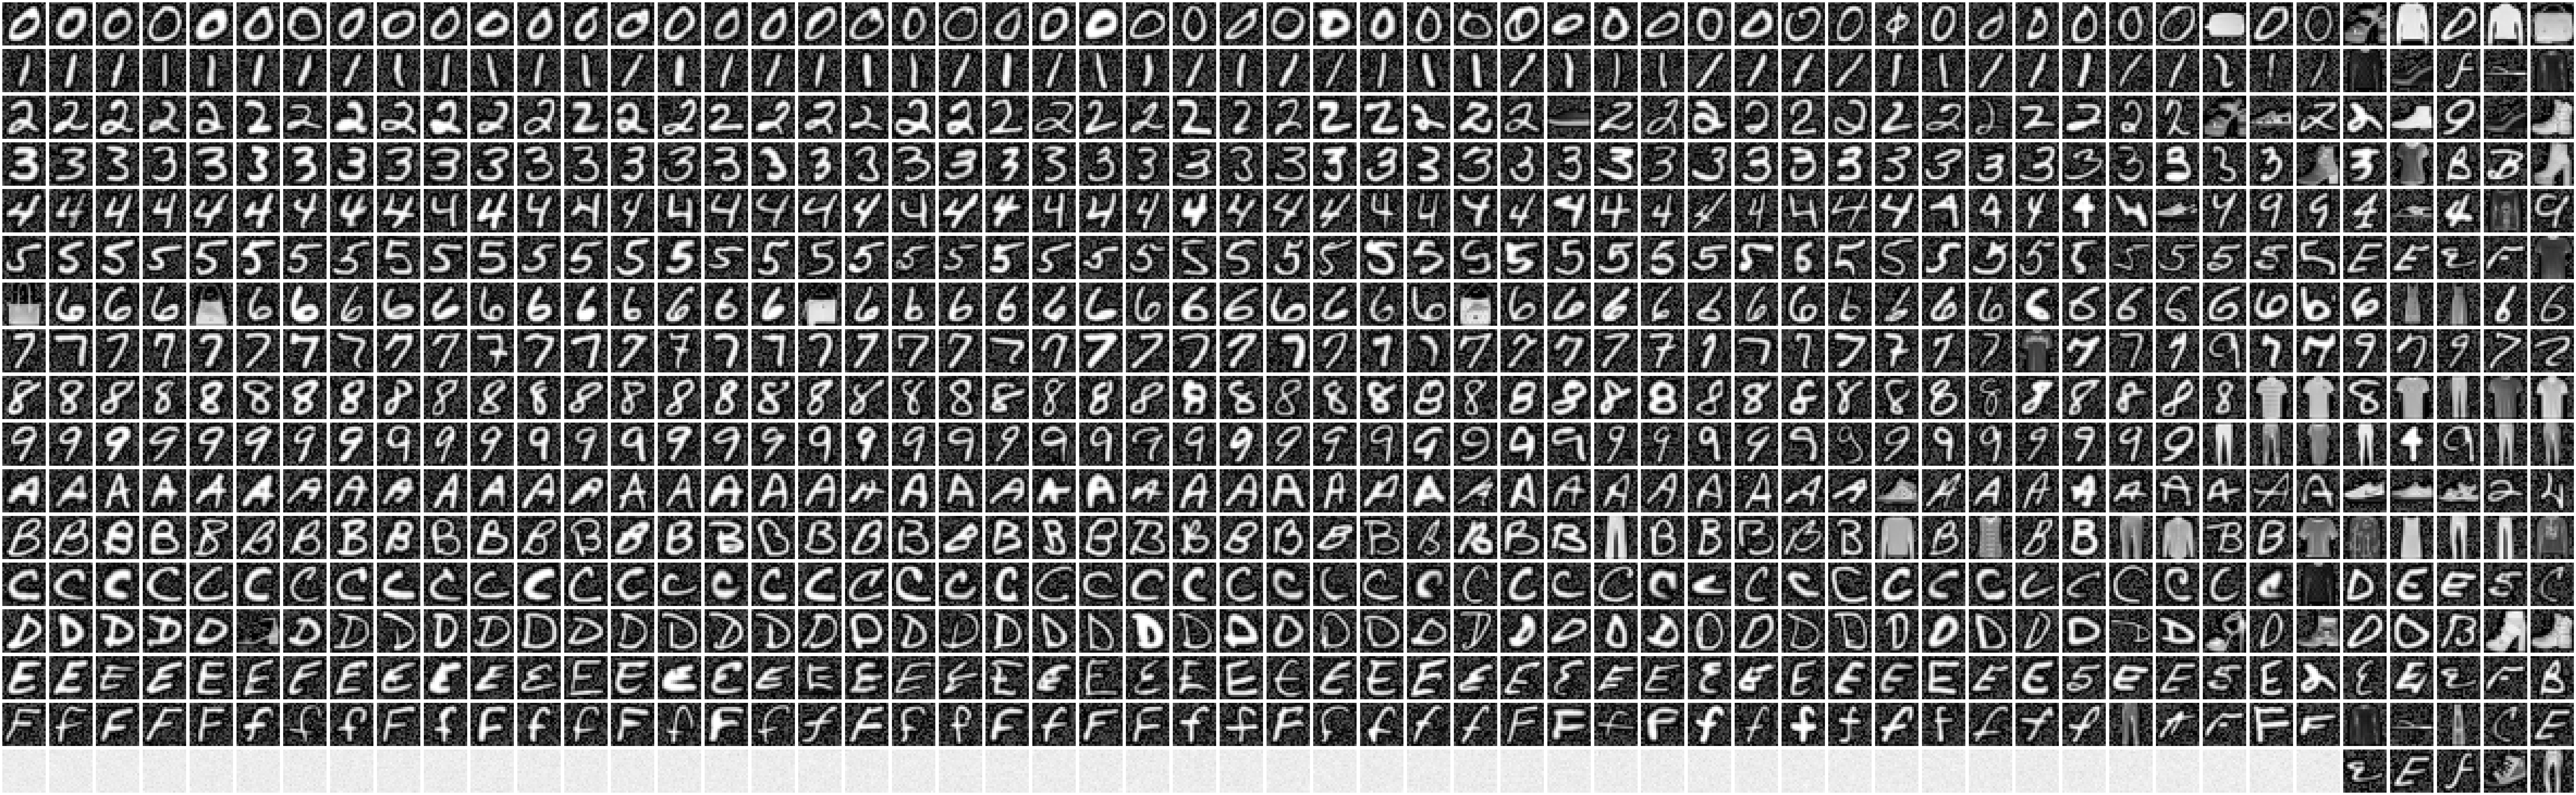

In [34]:
num_classes = predicts.shape[1]  # Number of classes
images_per_class = 55 # Number of images to show per class
image_size = (20, 20)  # Assuming 20x20 images as in your example

fig, axes = plt.subplots(num_classes, images_per_class, figsize=(images_per_class * 2, num_classes * 2))

# Step 3: Loop over each class and find the most confident images
for class_idx in range(num_classes):
    # Sort the images by probability for the current class
    most_confident_indices = np.argsort(-predicts[:, class_idx])[:images_per_class]
    
    for img_idx, ax in enumerate(axes[class_idx]):
        image = X[most_confident_indices[img_idx]].reshape(image_size)
        ax.imshow(image, vmin=0, vmax=1, cmap="gray")
        ax.axis('off')  # Turn off axis labels

    # Add a class label on the left
    axes[class_idx, 0].set_ylabel(f'Class {class_idx}', fontsize=12, labelpad=10)

# Show the figure
plt.tight_layout()
plt.show()


### Above we can see all of the images in the dataset, we see that a lot of them look like clothes


# Finding the out of distribution images:

In [35]:
# predicts_proba = best_svm.predict_proba(X)
predicts_proba = svm.predict_proba(X_corrupt_pca)

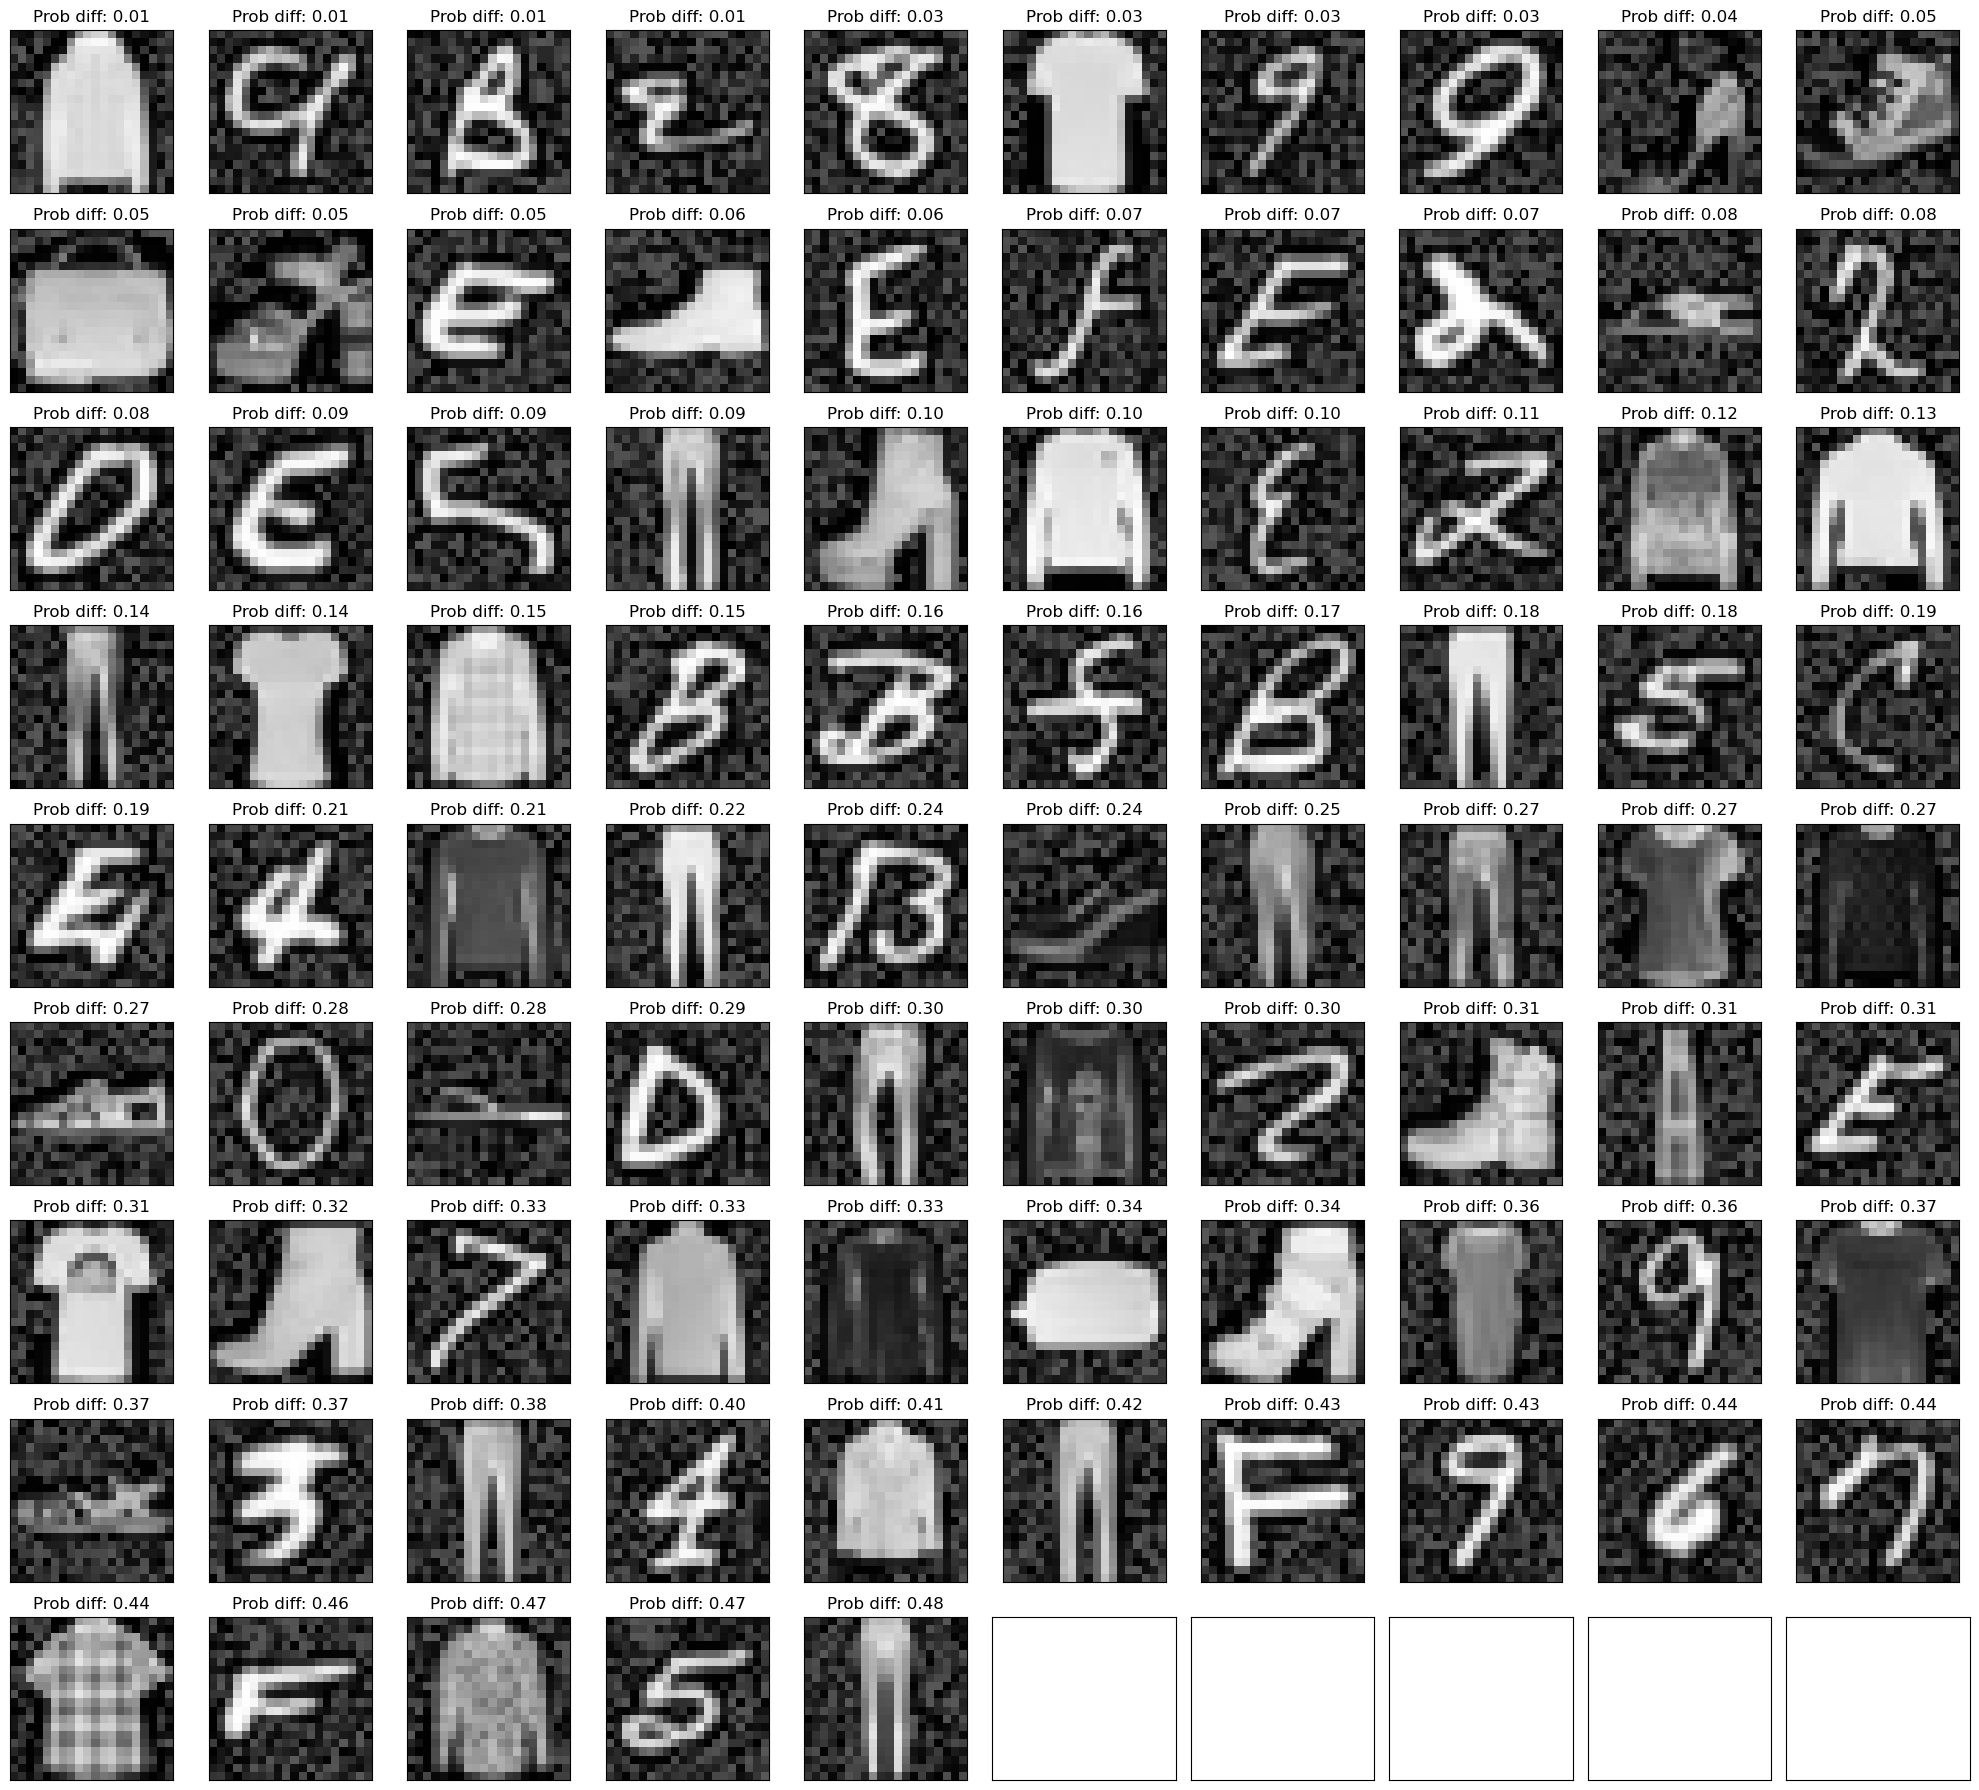

In [36]:

# Step 1: Calculate the difference between the highest and second-highest probabilities
sorted_probs = np.sort(predicts_proba, axis=1)  # Sort the probabilities for each image
prob_diffs = sorted_probs[:, -1] - sorted_probs[:, -2]  # Difference between the two largest probabilities

# Step 2: Sort by uncertainty (smallest difference = most uncertain)
most_uncertain_indices = np.argsort(prob_diffs)  # Sorted from smallest to largest difference

# Step 3: Plot the most uncertain images, from highest uncertainty to lowest
num_uncertain = 85  # Number of most uncertain images to display
images_per_row = 10  # Number of images per row in the plot
num_rows = (num_uncertain + images_per_row - 1) // images_per_row  # Calculate number of rows

fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * 2, num_rows * 2))

for i, ax in enumerate(axes.flat):
    if i < num_uncertain:
        image_idx = most_uncertain_indices[i]  # Start with the most uncertain
        image = X[image_idx].reshape(20, 20)  # Assuming the images are 20x20
        ax.imshow(image, vmin=0, vmax=1, cmap="gray")
        ax.set_title(f"Prob diff: {prob_diffs[image_idx]:.2f}")
    ax.set_xticks([])  # Remove x-axis ticks
    ax.set_yticks([])  # Remove y-axis ticks

plt.tight_layout()
plt.show()


### Results for calculating the difference between the highest and second-highest probabilities:
39/85!


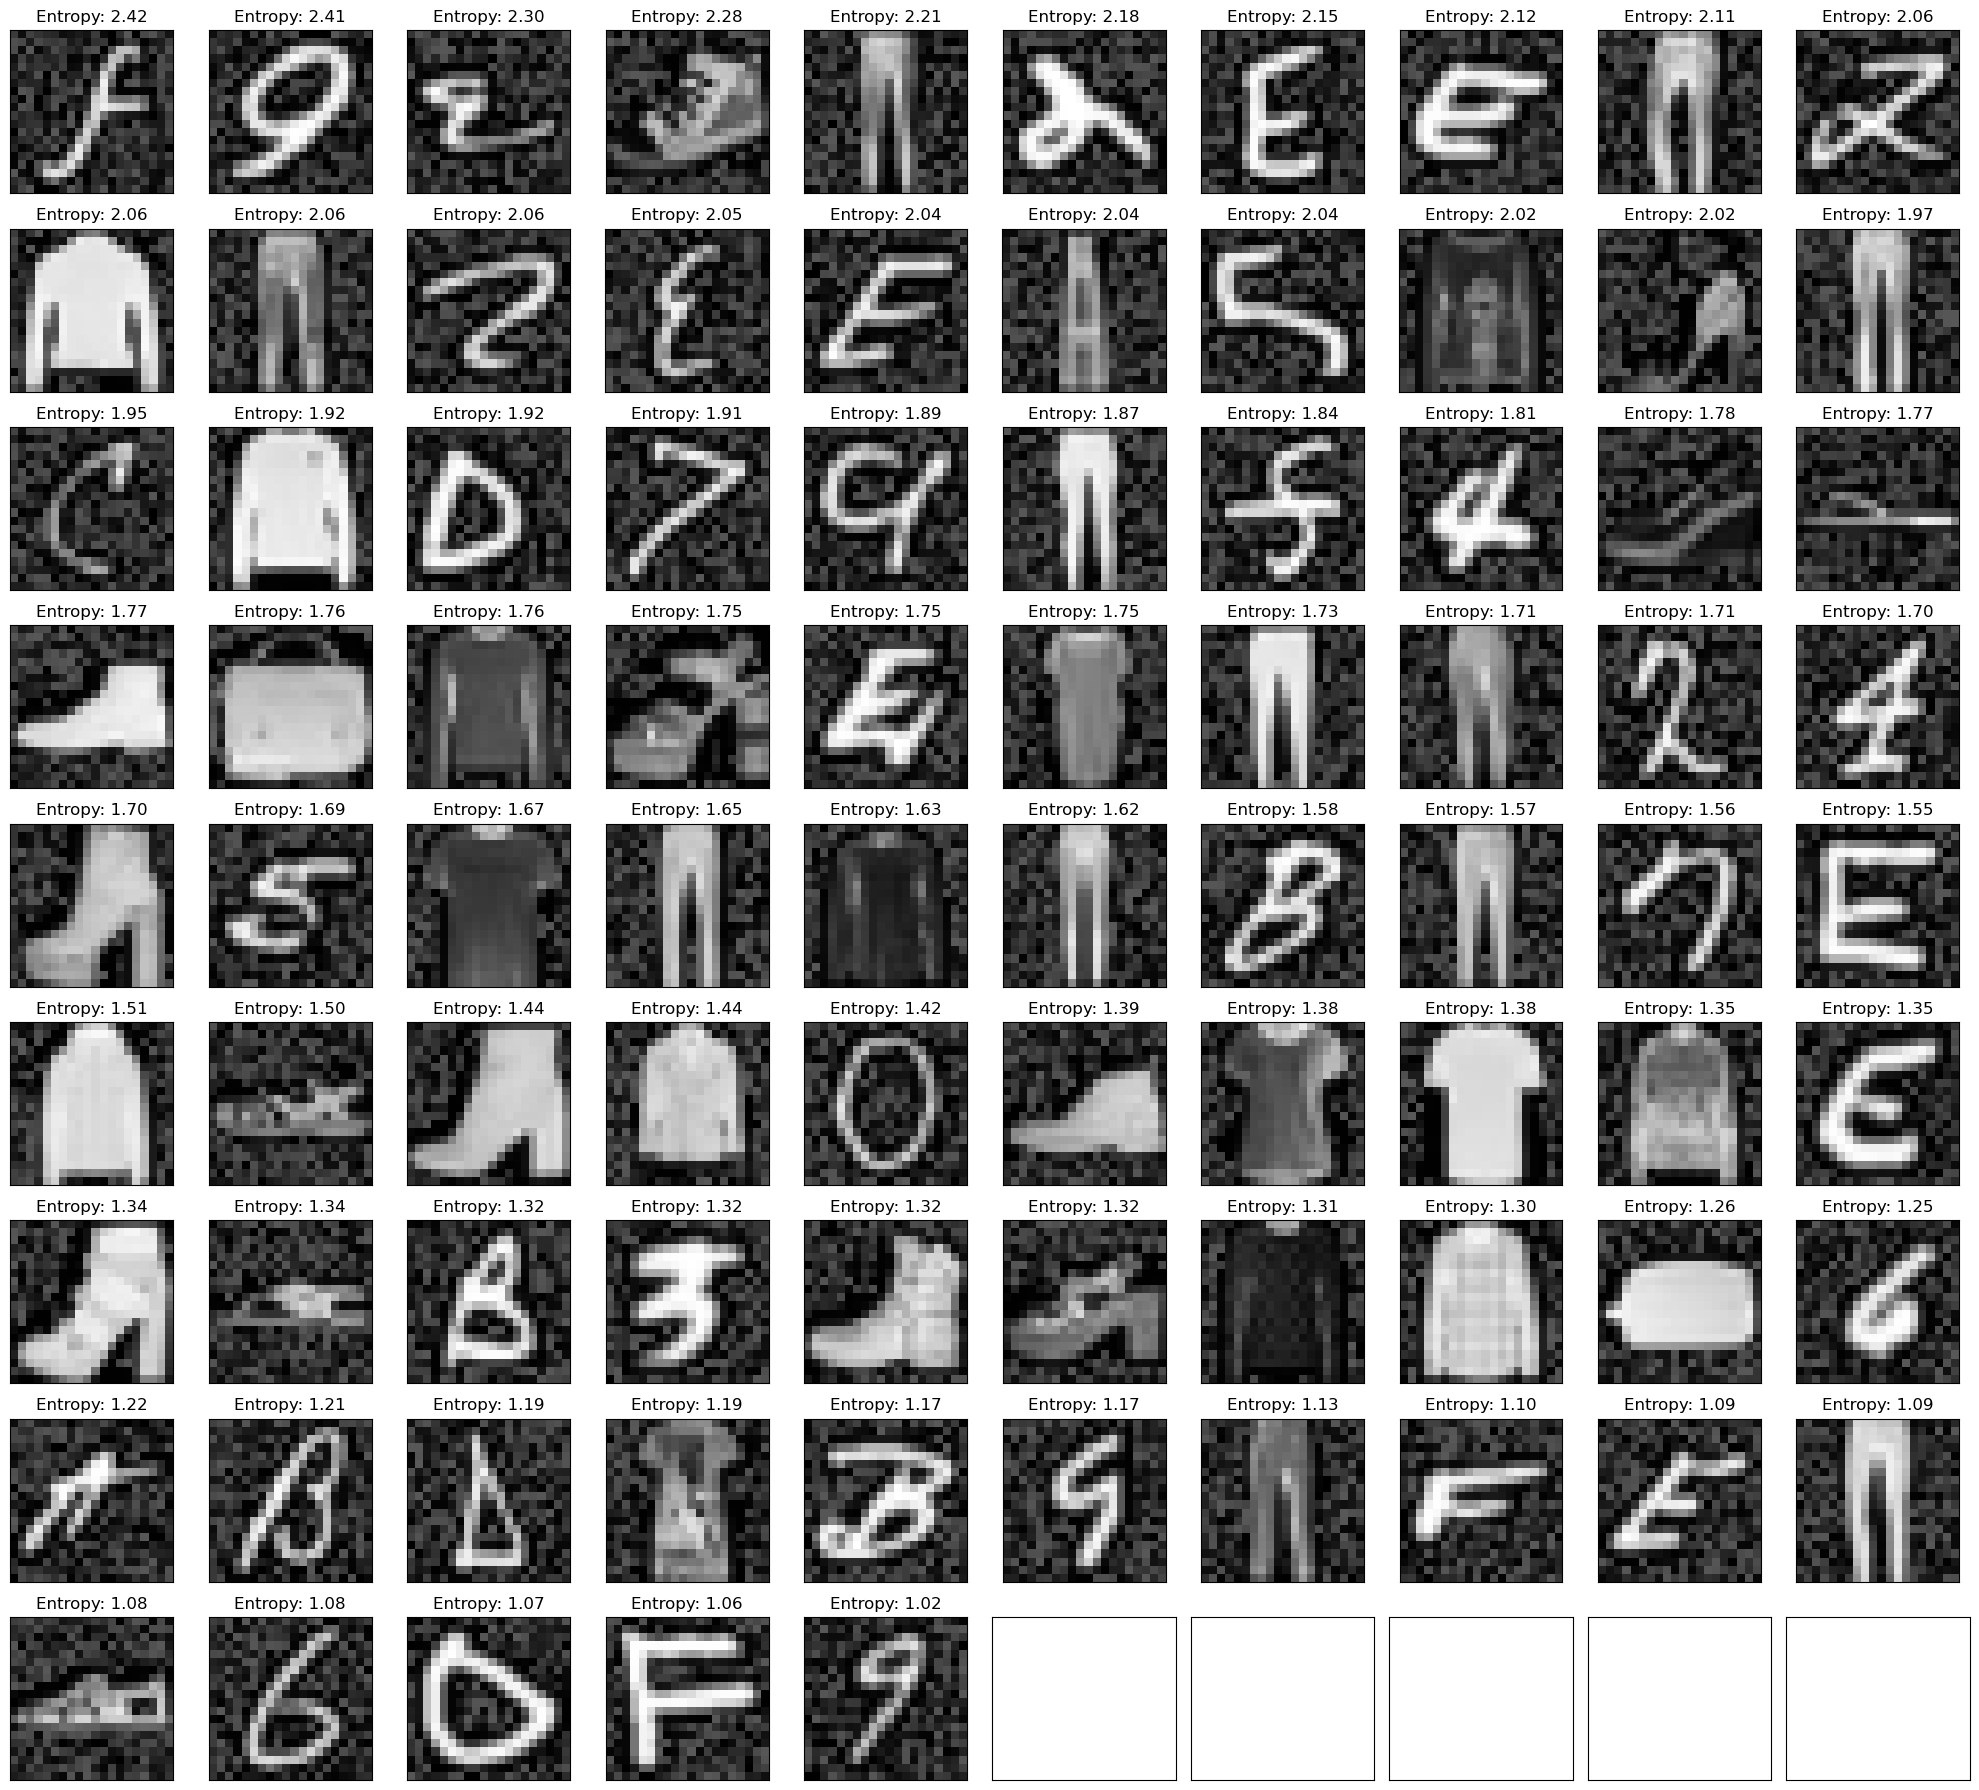

In [37]:
from scipy.stats import entropy

# Step 1: Calculate entropy for each image
entropies = np.apply_along_axis(entropy, 1, predicts_proba)  # Apply entropy along axis 1

# Step 2: Sort by entropy (highest entropy = most uncertain)
most_uncertain_indices = np.argsort(entropies)[::-1]  # Sort in descending order of entropy

# Step 3: Plot the most uncertain images based on entropy
num_uncertain = 85 # Number of most uncertain images to display
images_per_row = 10  # Number of images per row in the plot
num_rows = (num_uncertain + images_per_row - 1) // images_per_row  # Calculate number of rows

fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * 2, num_rows * 2))

for i, ax in enumerate(axes.flat):
    if i < num_uncertain:
        image_idx = most_uncertain_indices[i]
        image = X[image_idx].reshape(20, 20)  # Assuming the images are 20x20
        ax.imshow(image, vmin=0, vmax=1, cmap="gray")
        ax.set_title(f"Entropy: {entropies[image_idx]:.2f}")
    ax.set_xticks([])  # Remove x-axis ticks
    ax.set_yticks([])  # Remove y-axis ticks

plt.tight_layout()
plt.show()


### Result for calculating the entropy for each image:
43/85

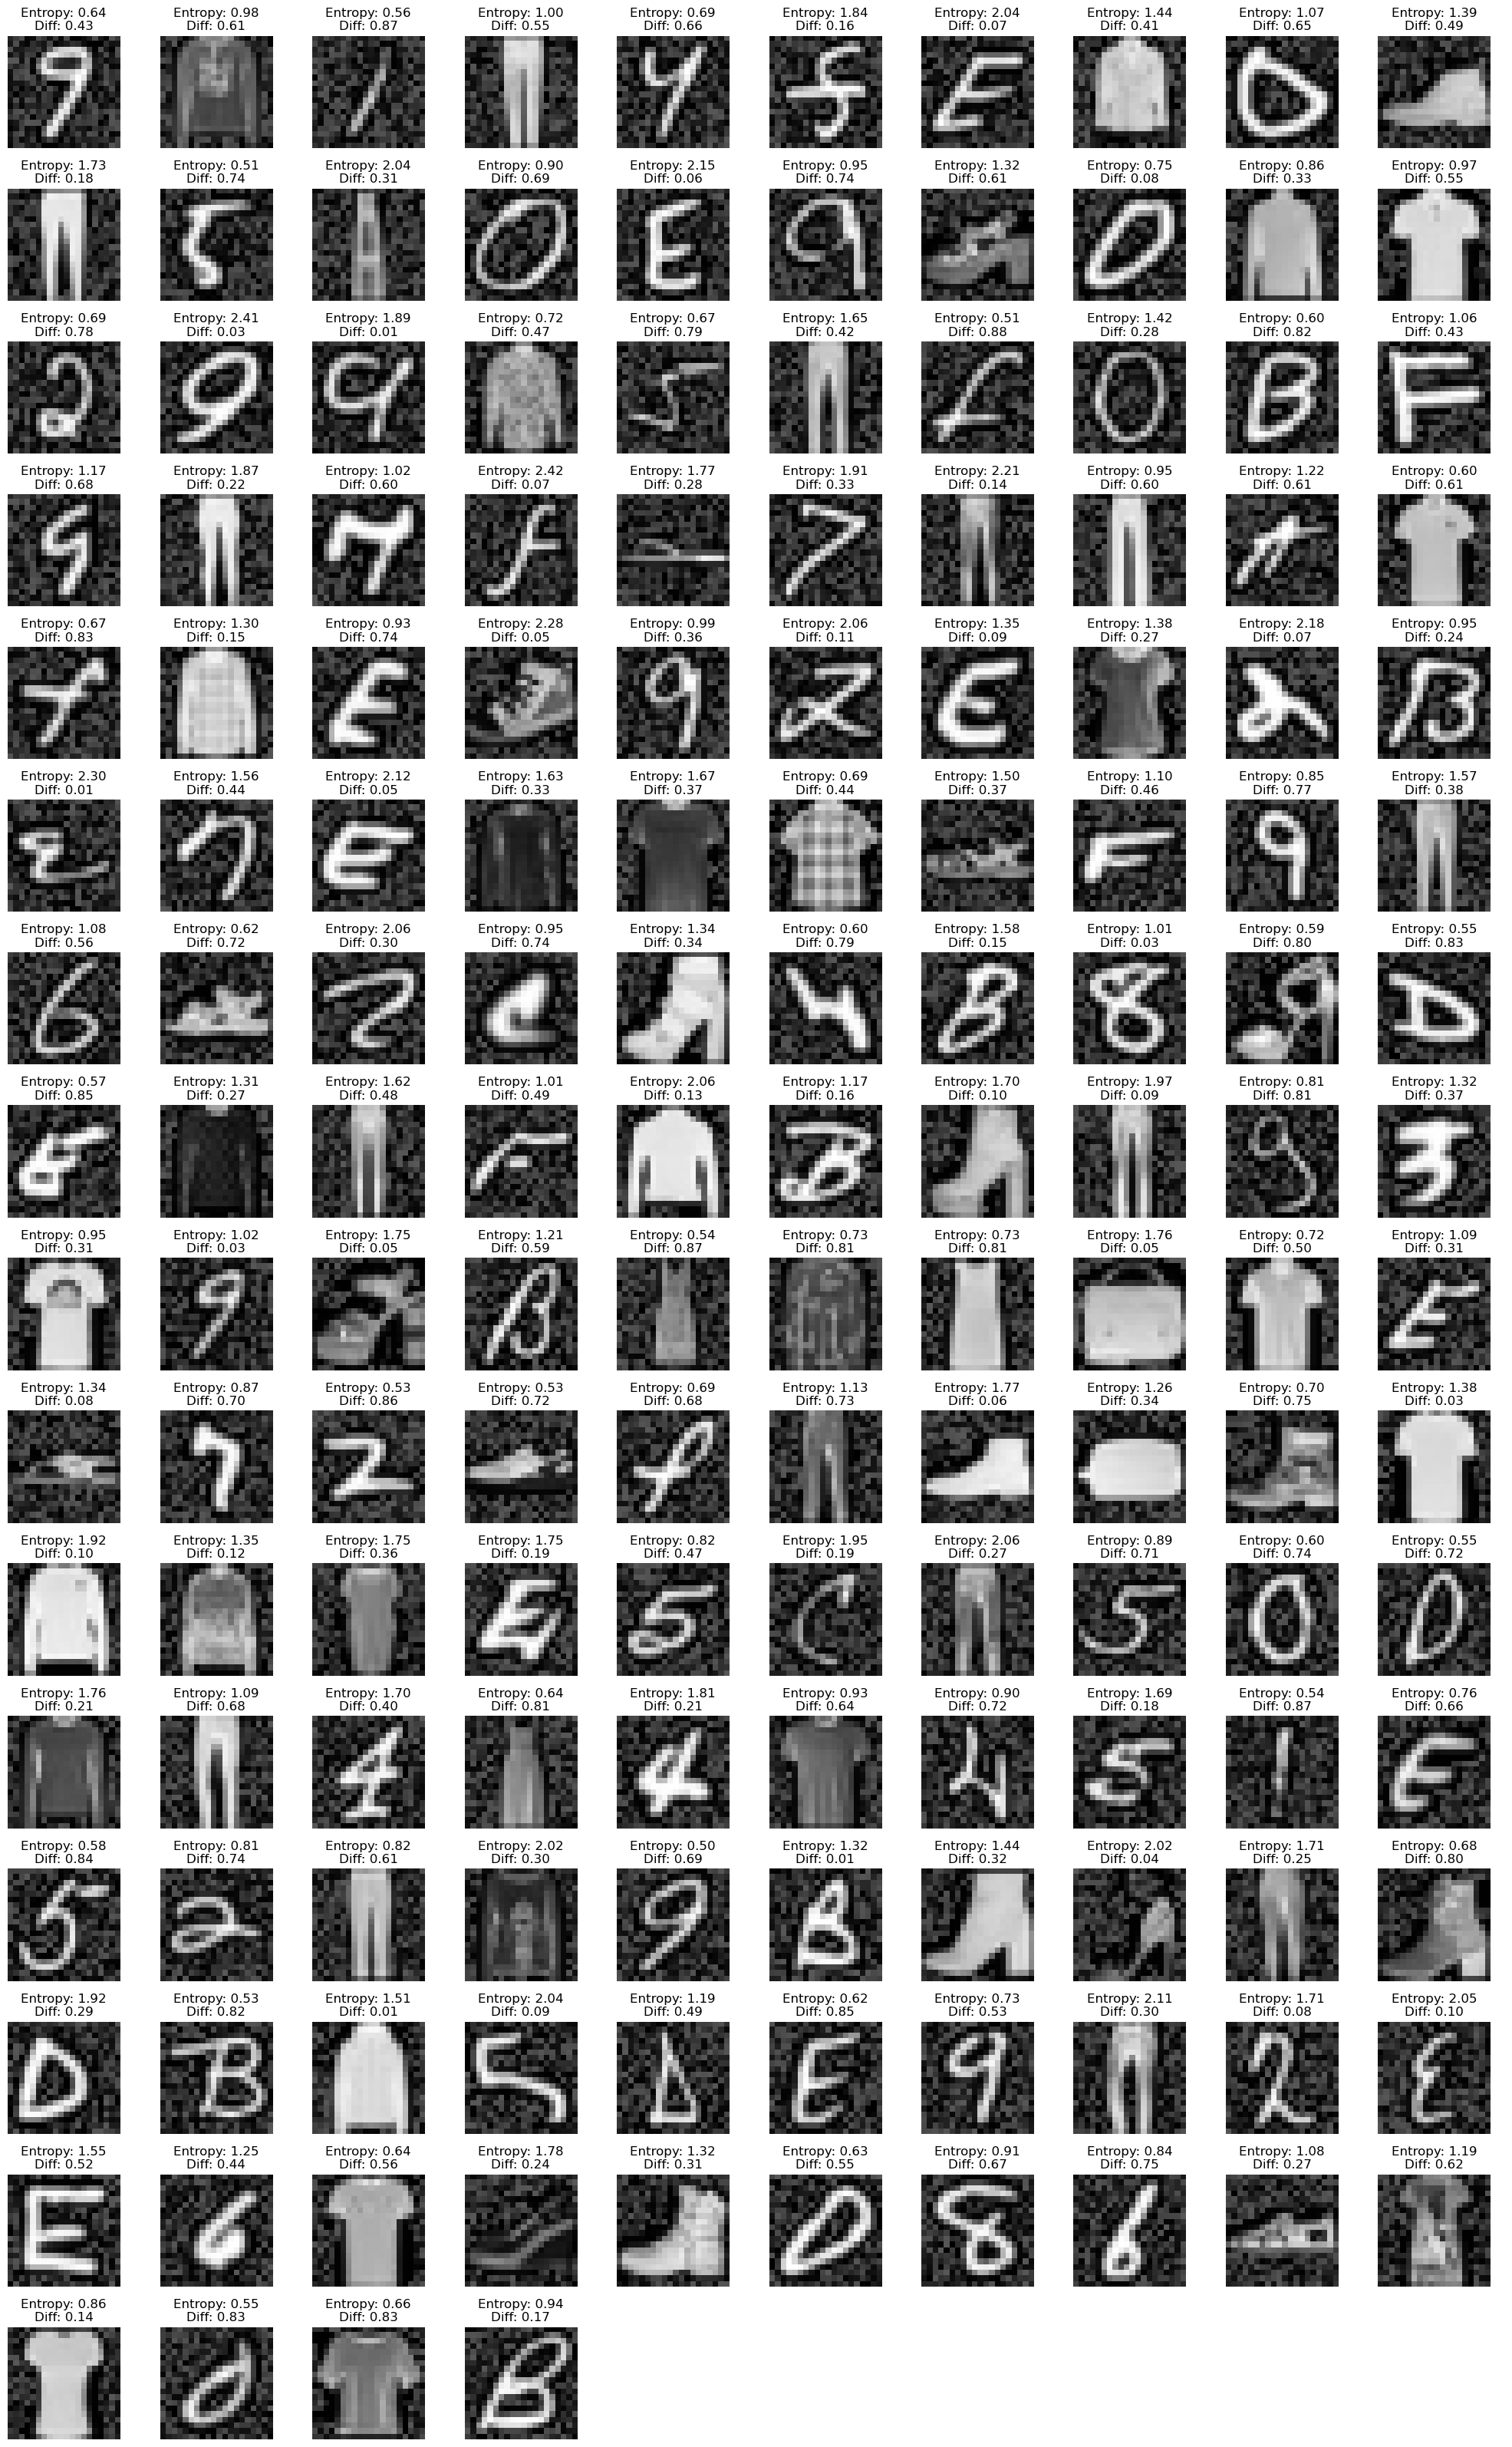

In [38]:
from scipy.stats import entropy

# Step 1: Calculate entropy for each image
entropies = np.apply_along_axis(entropy, 1, predicts_proba)

# Step 2: Combine probability differences and entropy
threshold_diff = 0.1  # You can tune this
threshold_entropy = 0.5  # You can tune this

# Flag images with small probability difference or high entropy
flagged_indices = np.where((prob_diffs < threshold_diff) | (entropies > threshold_entropy))[0]

# Step 3: Plot flagged images
num_flagged = len(flagged_indices)
fig, axes = plt.subplots((num_flagged + 9) // 10, 10, figsize=(20, 2 * (num_flagged + 9) // 10))

for i, ax in enumerate(axes.flat):
    if i < num_flagged:
        image_idx = flagged_indices[i]
        image = X[image_idx].reshape(20, 20)
        ax.imshow(image, cmap='gray', vmin=0, vmax=1)
        ax.set_title(f"Entropy: {entropies[image_idx]:.2f}\nDiff: {prob_diffs[image_idx]:.2f}")
    ax.axis('off')

plt.tight_layout()
plt.show()
